In [1]:
import numpy as np 
import scipy.io as sio
import os, os.path
import sys
import tensorflow as tf
import re
import glob
import SimpleITK as sitk
import scipy.ndimage
from PIL import Image
from random import shuffle
import nibabel as nib

In [2]:
brats_data_dir = "C:\\Users\\rober\\Practicas\\MICCAI_BraTS17_Data_Training\\HGG\\"

In [3]:
class_names = ['flair','t1','t2','t1ce']
class_names

['flair', 't1', 't2', 't1ce']

In [4]:
print("Size of:")
print(len((glob.glob(brats_data_dir+'*'))))

Size of:
210


In [5]:
brats_paciente_zero = brats_data_dir+'\\Brats17_2013_2_1\\'
brats_paciente_zero

'C:\\Users\\rober\\Practicas\\MICCAI_BraTS17_Data_Training\\HGG\\\\Brats17_2013_2_1\\'

In [6]:
print(len(glob.glob(brats_paciente_zero+'*')))

5


VAMOS A VER SI PODEMOS VER LAS FOTOS

In [7]:
nombre_imagen= brats_paciente_zero.split("\\")[-2]
nombre_imagen
img = nib.load(brats_paciente_zero+nombre_imagen+'_flair.nii.gz').get_data()
print(img.shape)

(240, 240, 155)


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

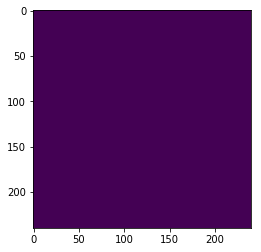

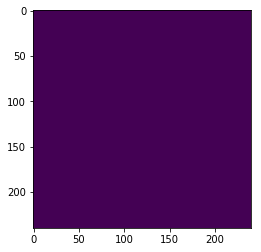

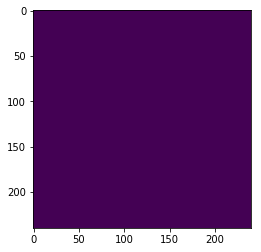

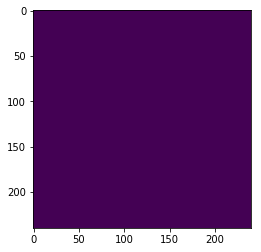

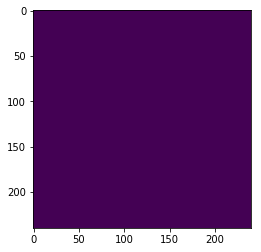

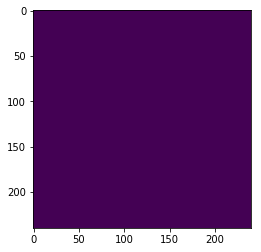

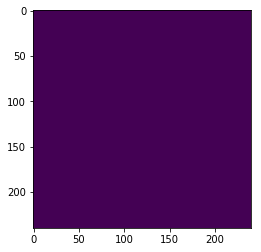

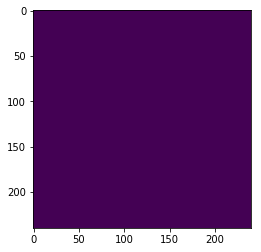

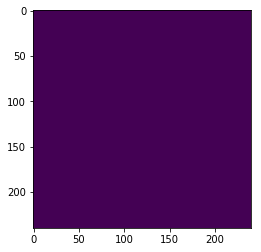

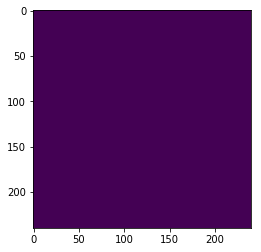

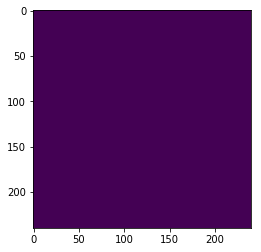

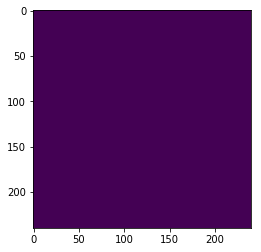

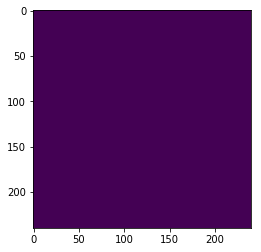

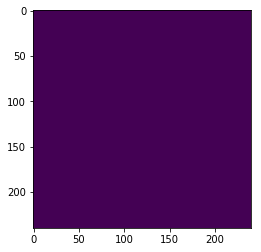

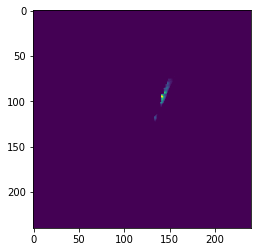

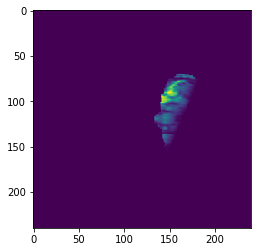

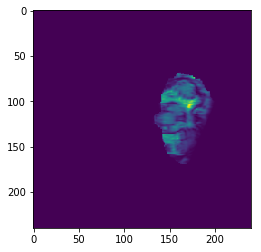

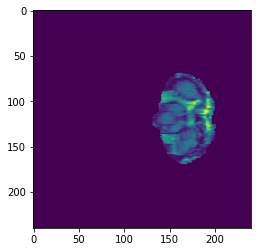

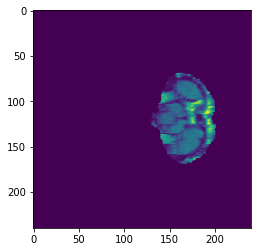

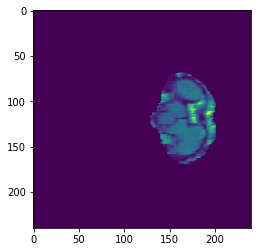

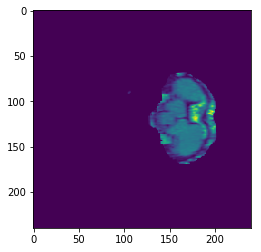

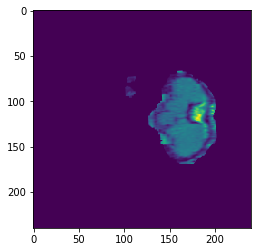

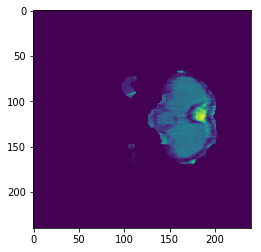

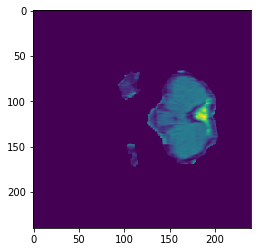

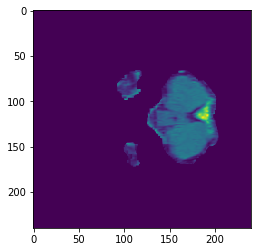

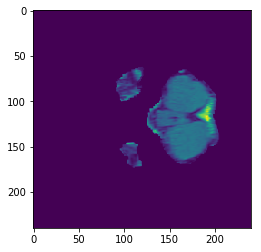

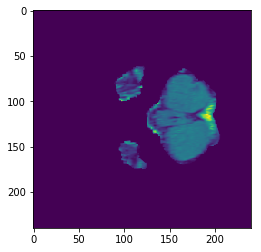

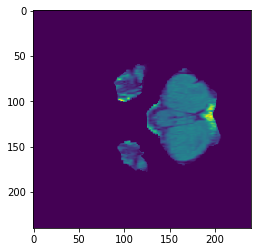

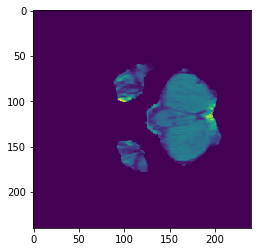

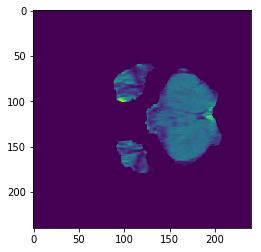

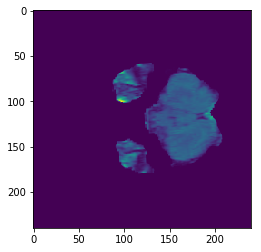

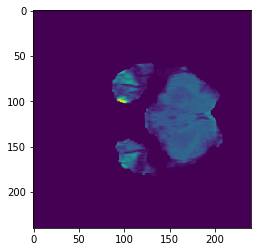

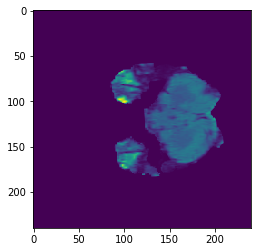

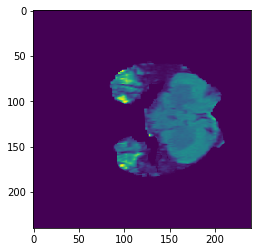

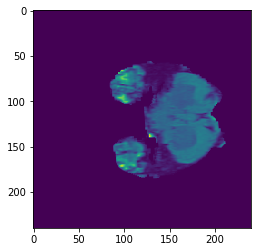

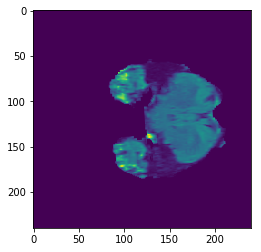

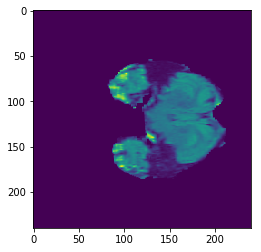

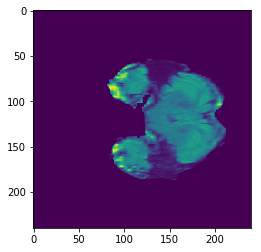

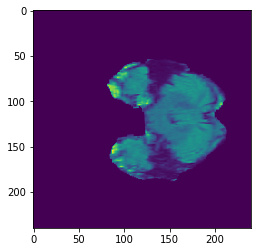

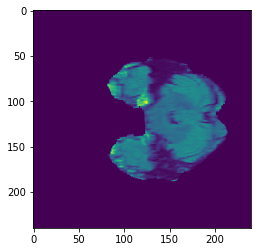

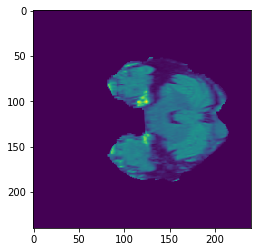

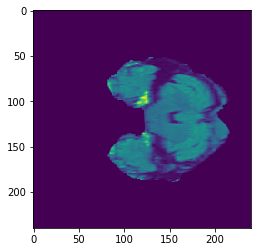

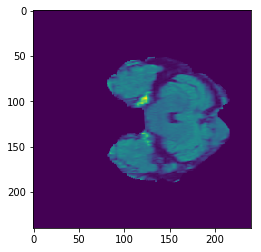

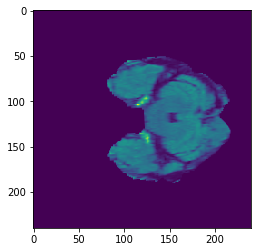

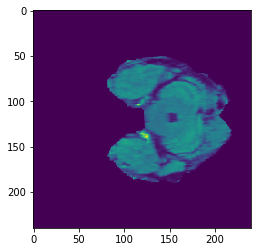

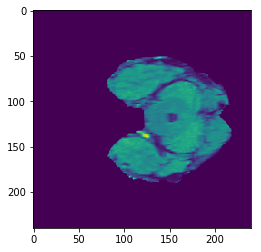

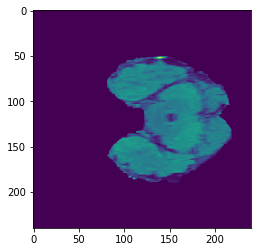

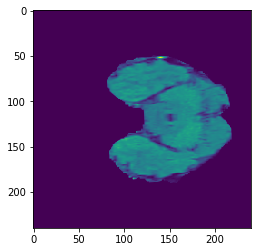

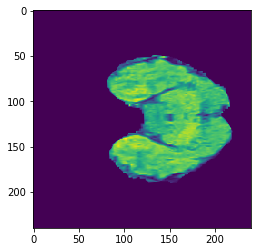

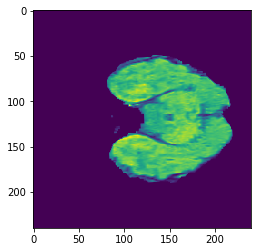

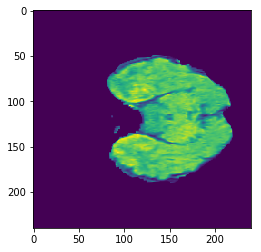

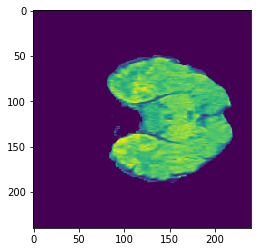

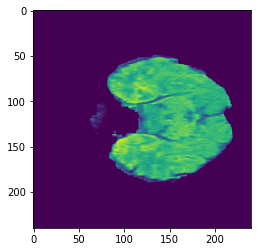

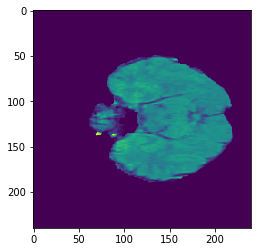

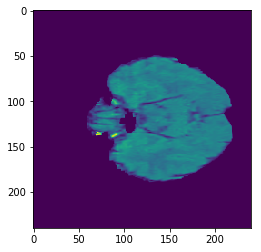

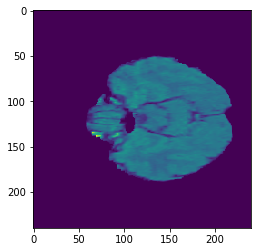

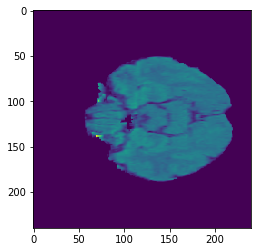

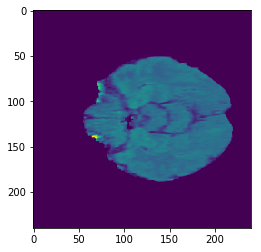

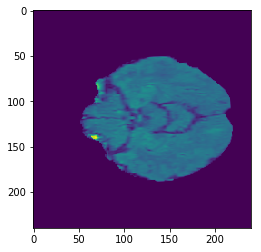

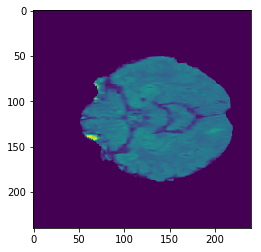

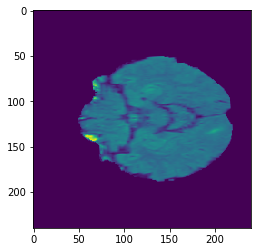

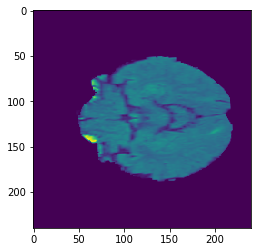

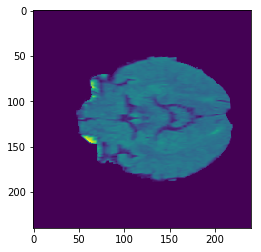

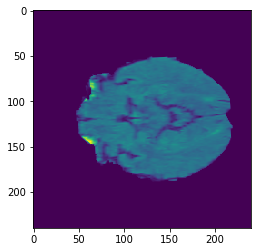

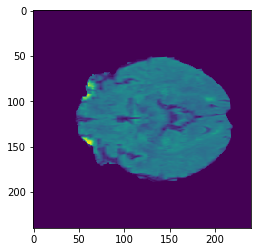

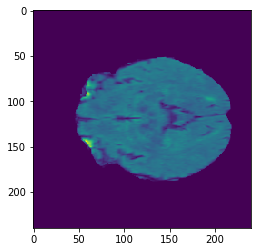

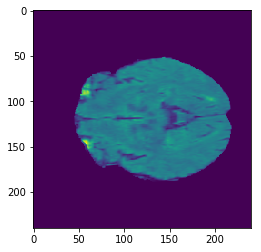

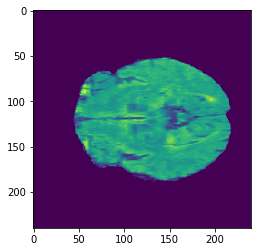

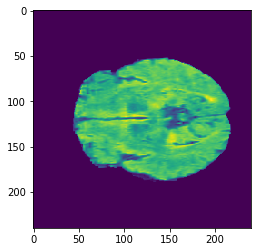

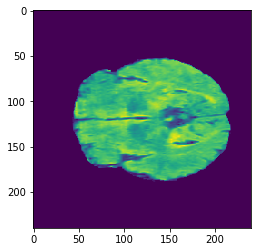

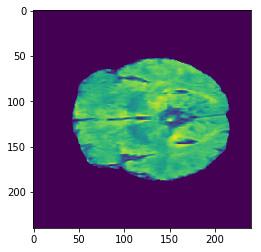

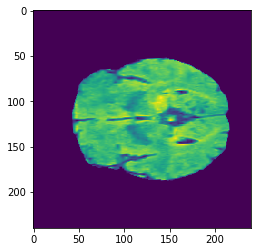

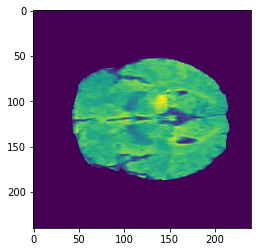

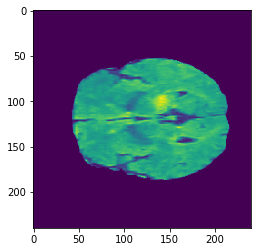

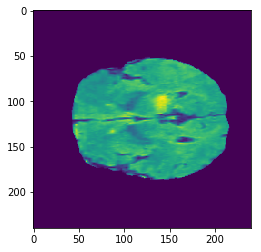

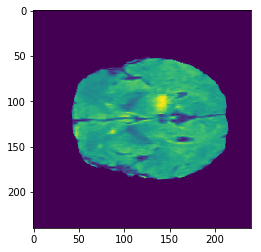

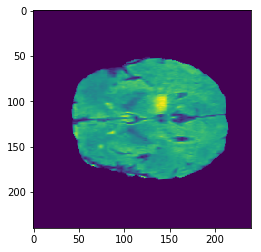

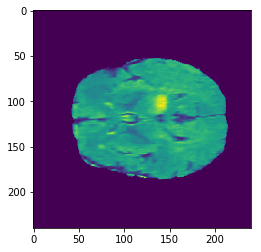

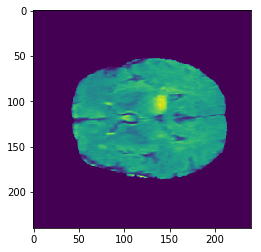

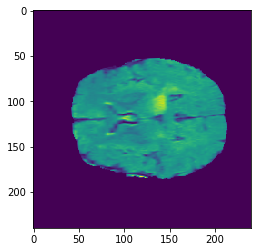

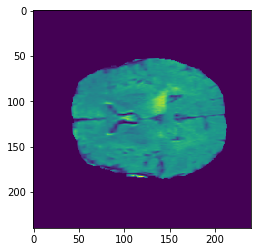

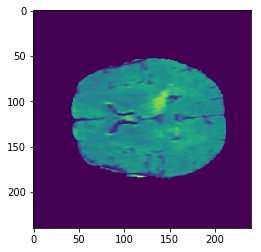

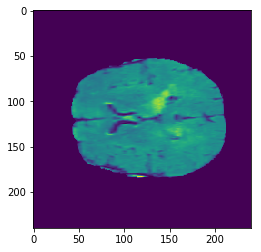

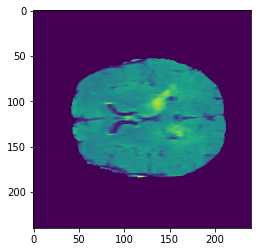

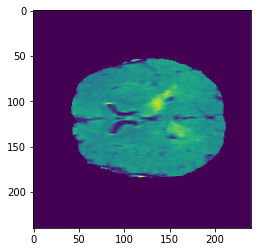

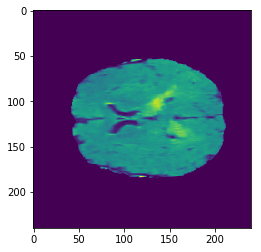

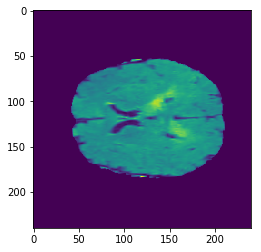

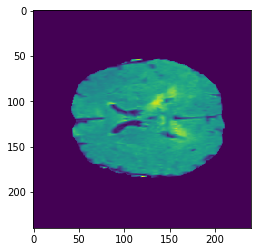

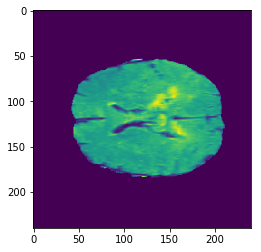

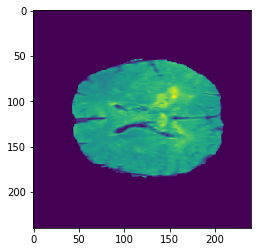

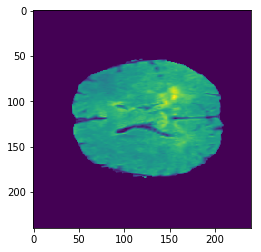

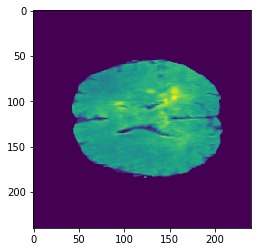

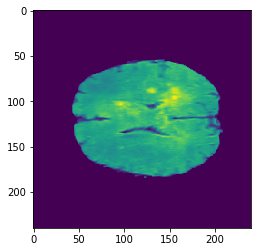

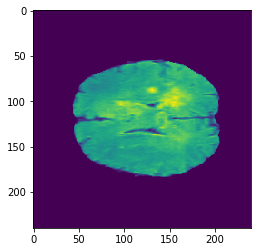

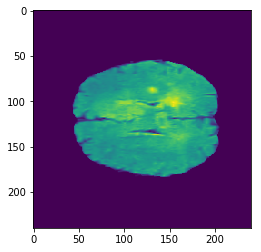

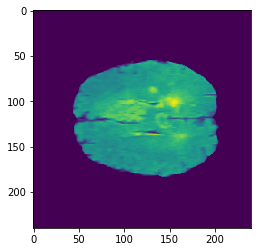

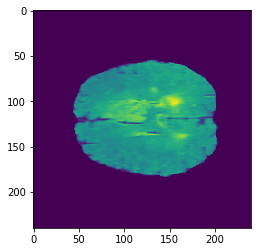

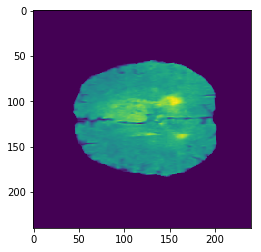

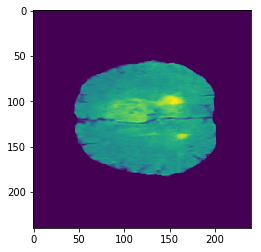

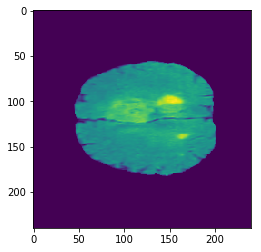

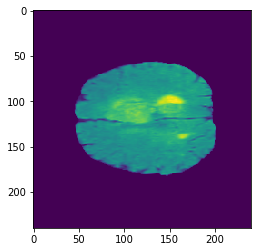

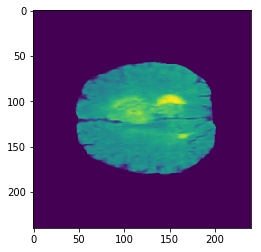

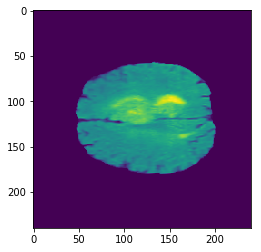

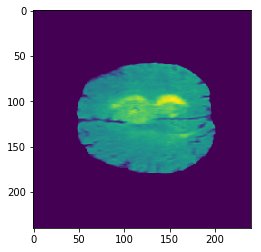

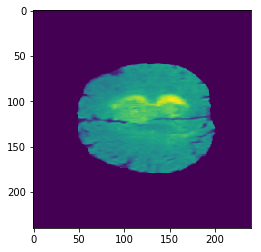

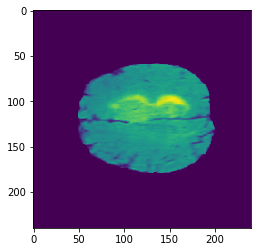

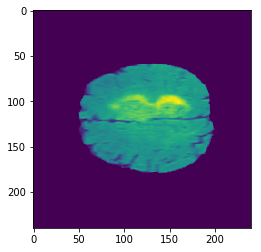

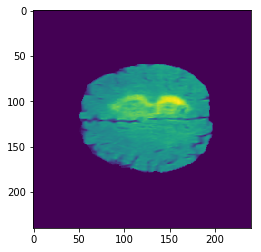

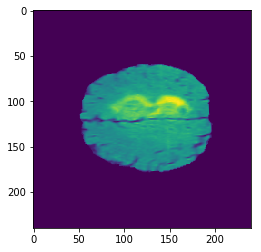

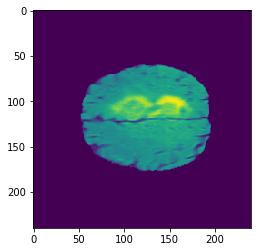

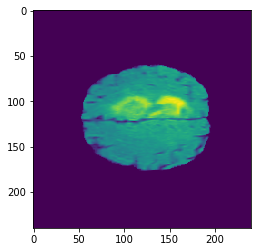

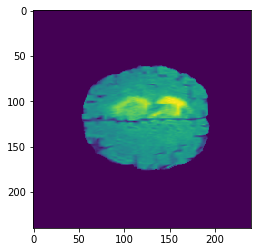

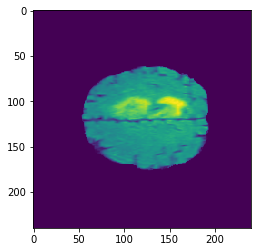

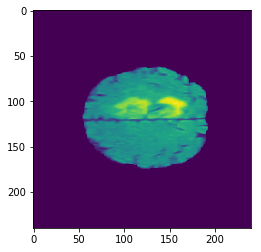

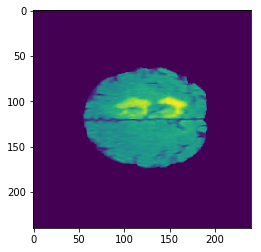

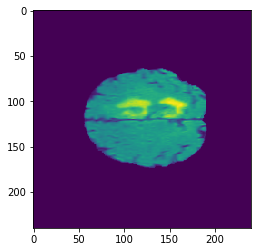

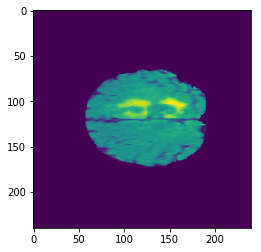

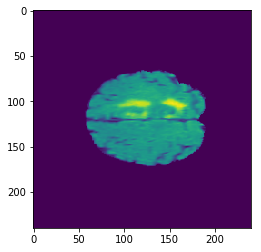

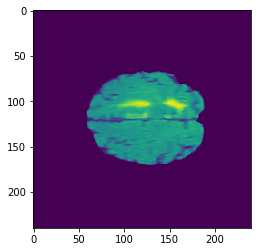

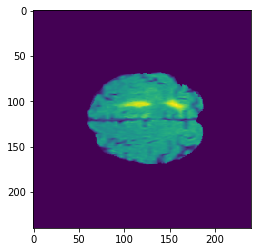

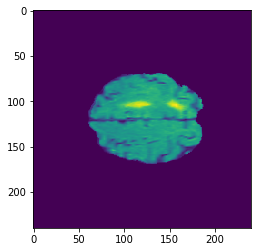

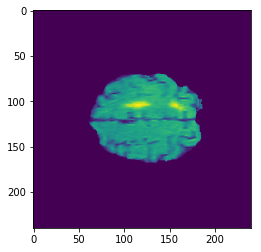

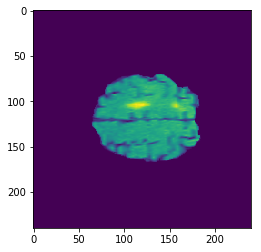

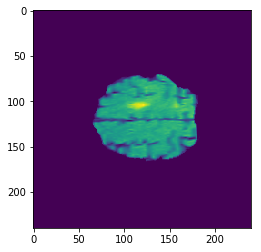

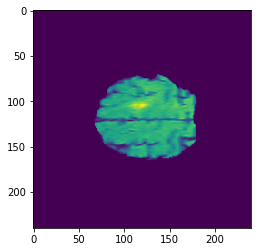

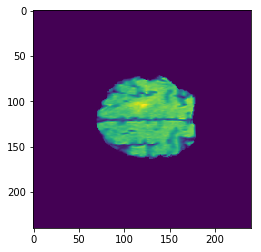

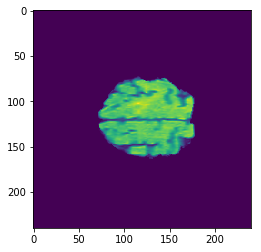

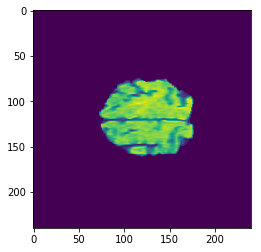

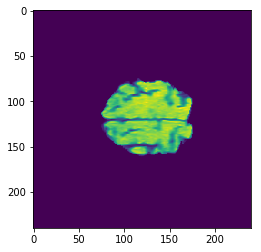

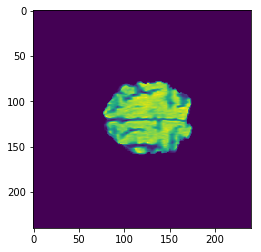

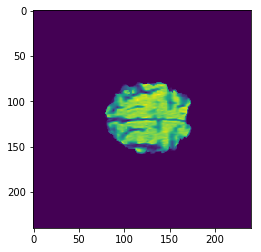

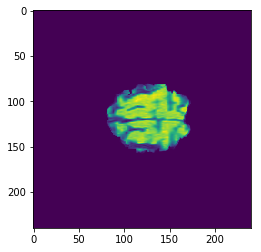

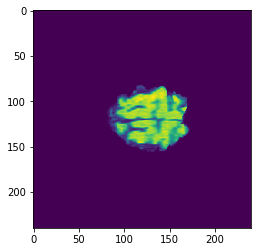

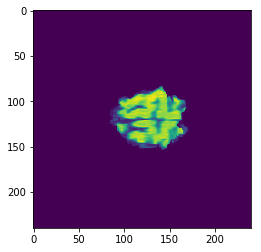

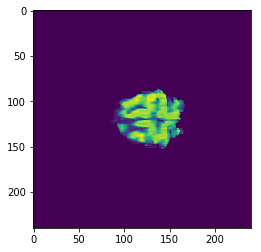

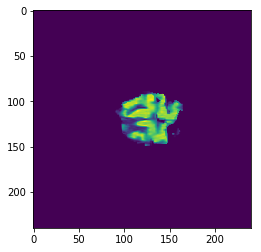

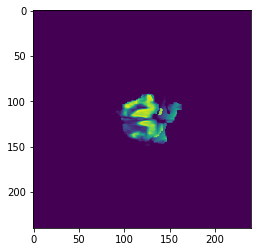

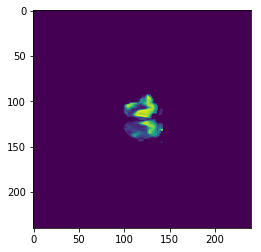

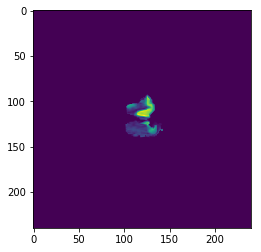

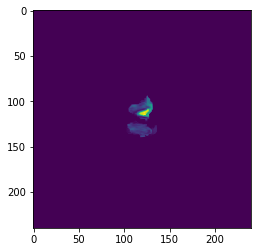

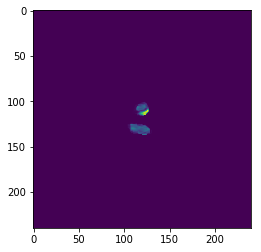

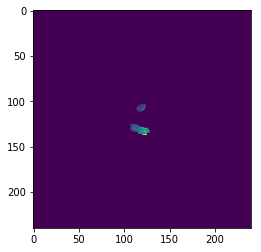

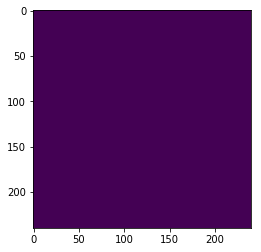

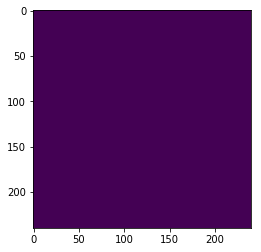

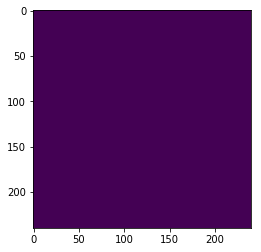

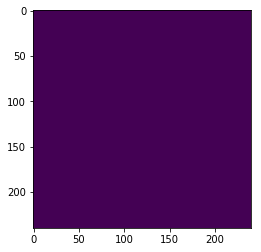

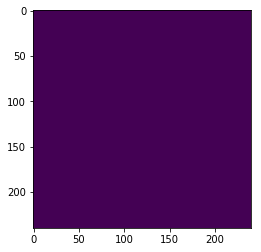

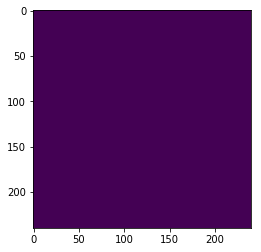

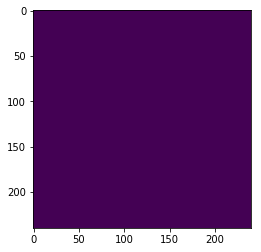

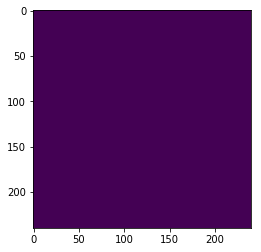

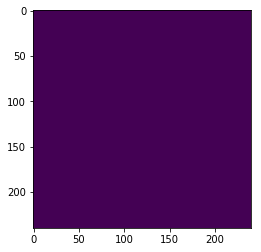

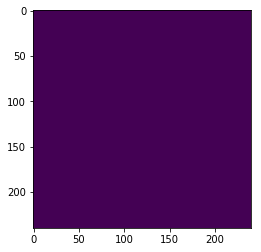

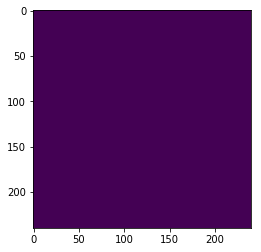

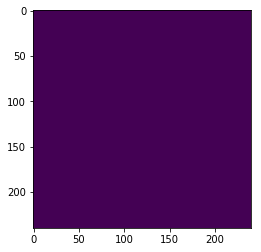

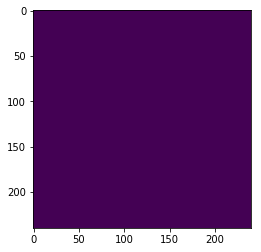

In [33]:
'''for i in range(0,155):
    plt.imshow(img[:,:,i])
    plt.show()'''

HEMOS COMPROBADO COMO PARA UN TIPO DE CORTE PODEMOS VER PARA UN PACIENTE
AHORA VEMOS A VER LA MÁSCARA SI FUNCIONA TAMBIEN

(240, 240, 155)


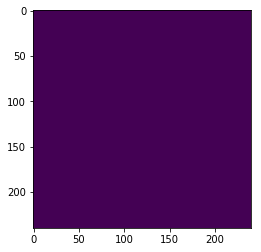

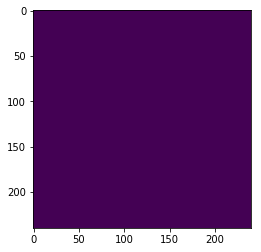

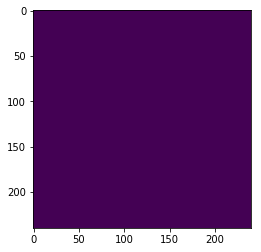

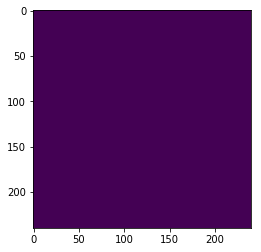

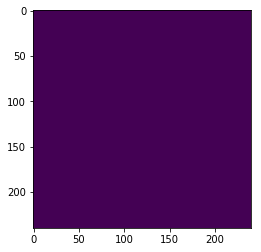

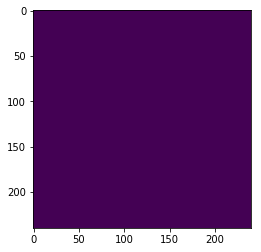

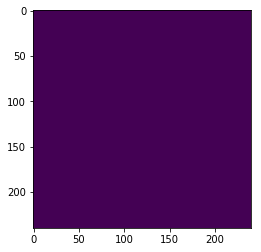

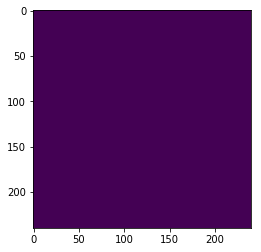

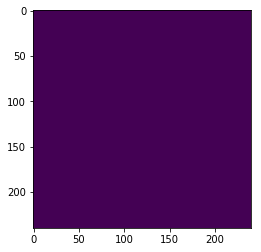

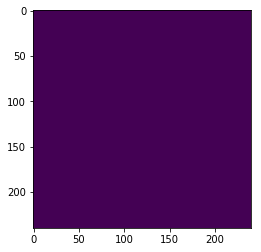

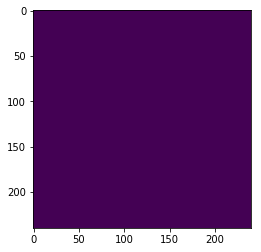

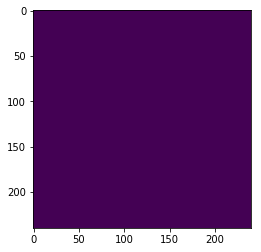

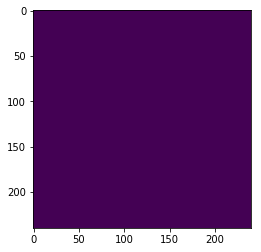

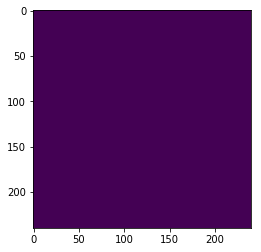

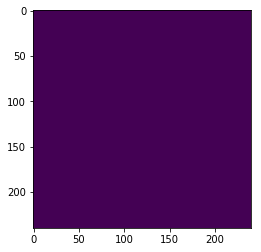

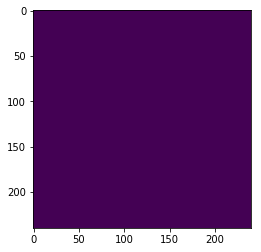

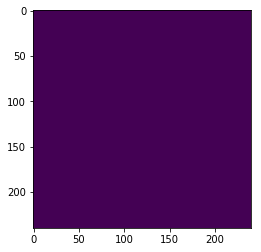

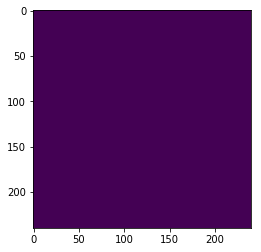

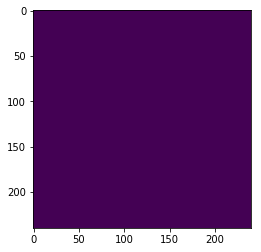

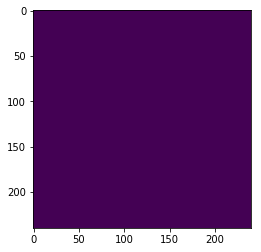

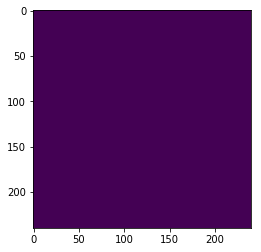

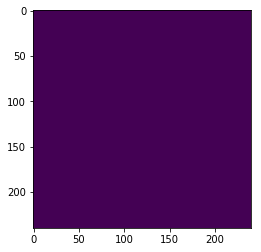

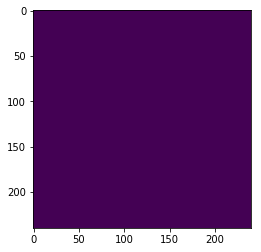

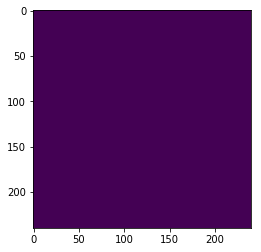

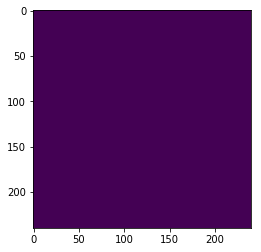

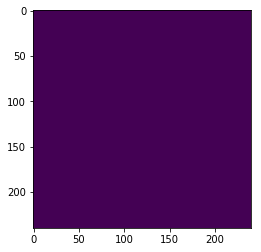

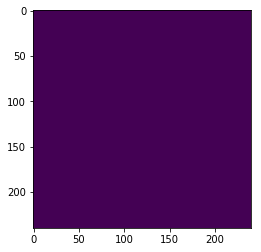

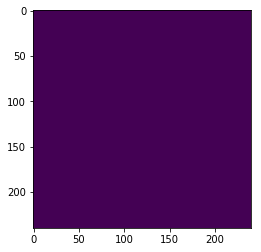

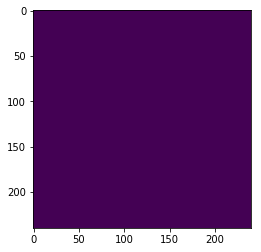

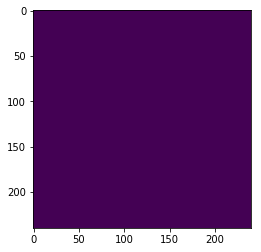

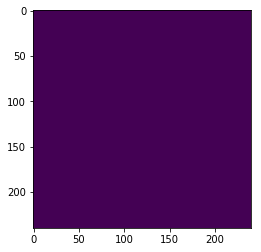

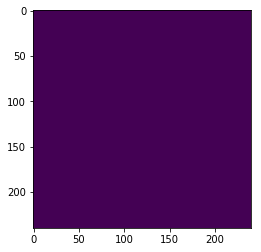

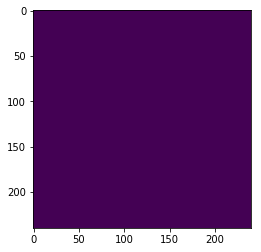

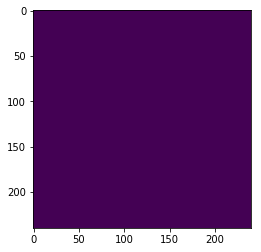

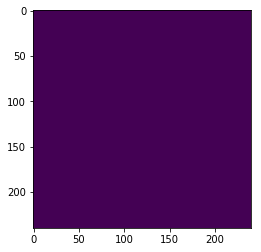

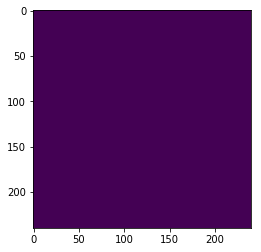

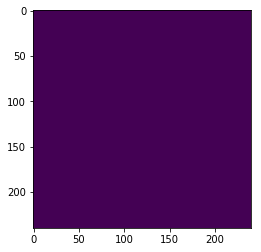

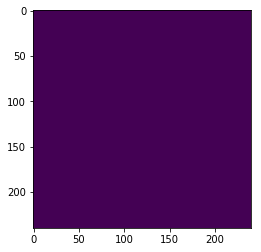

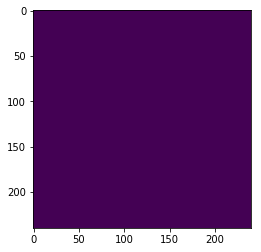

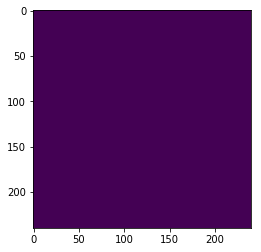

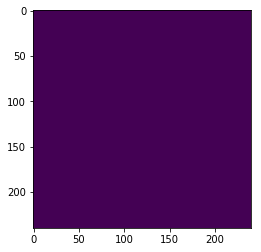

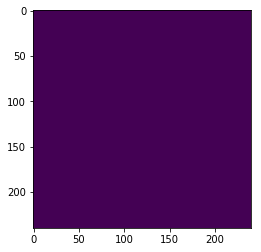

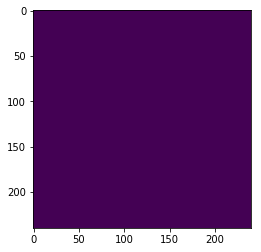

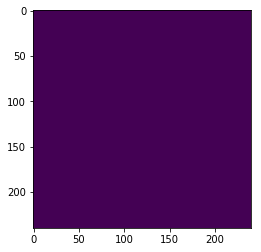

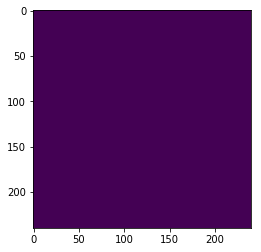

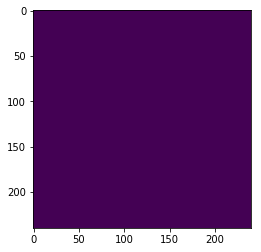

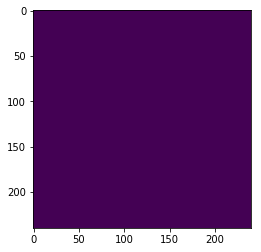

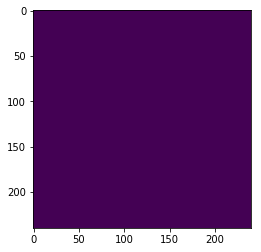

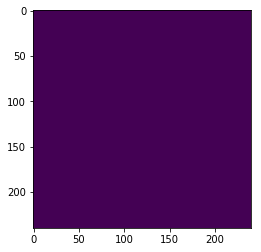

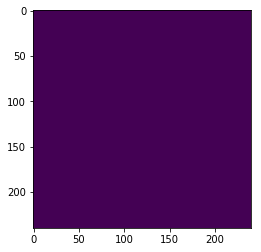

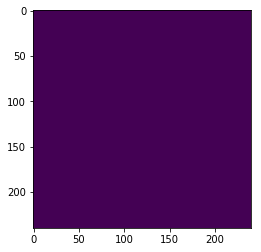

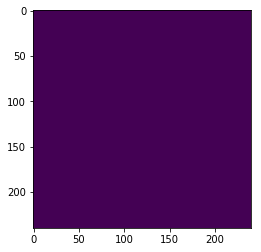

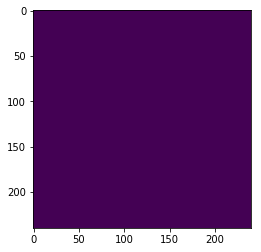

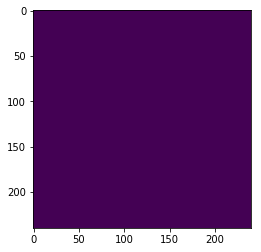

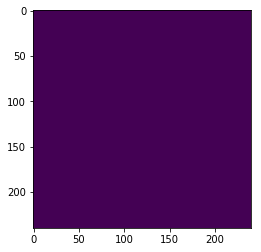

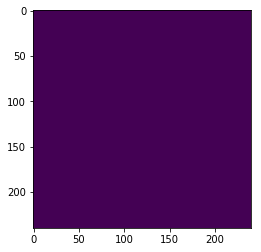

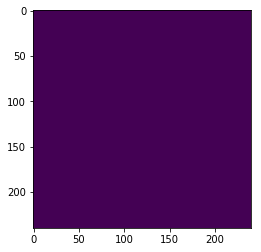

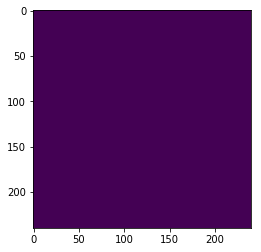

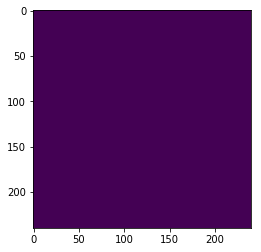

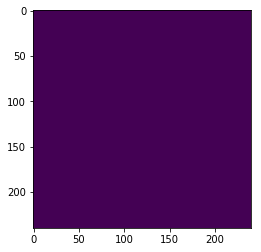

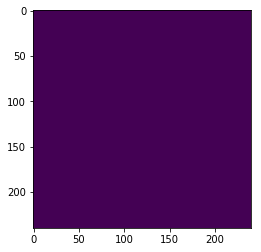

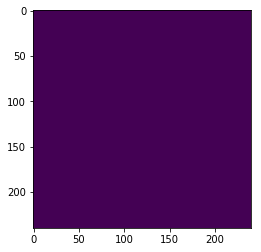

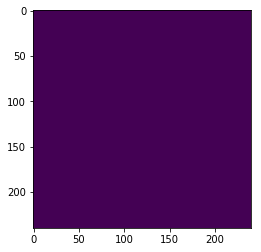

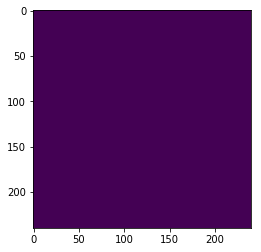

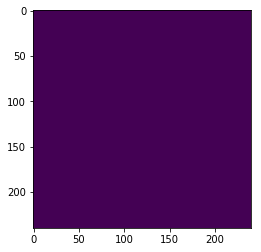

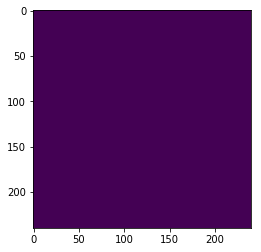

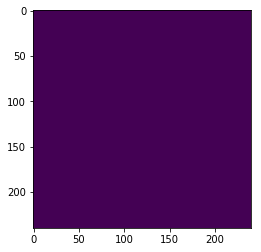

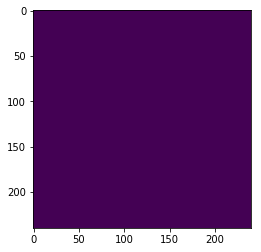

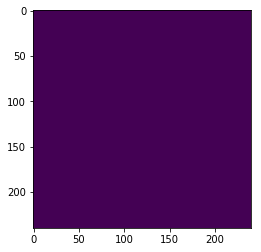

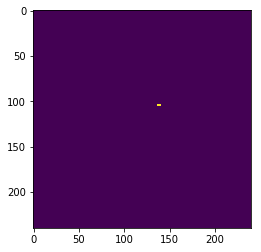

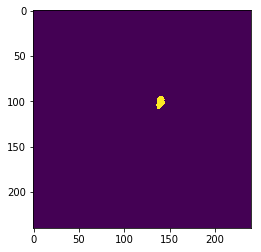

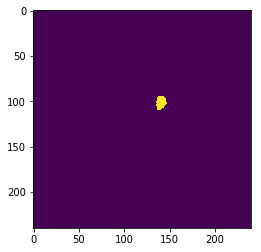

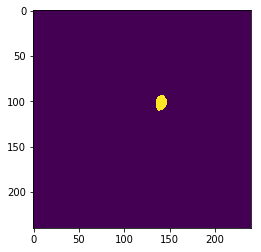

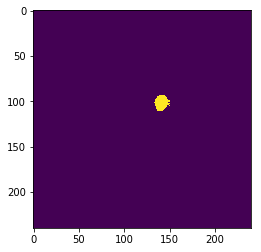

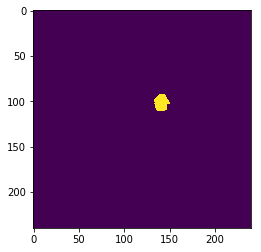

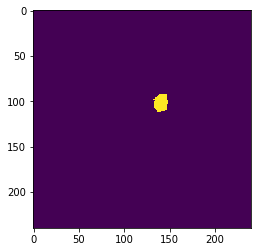

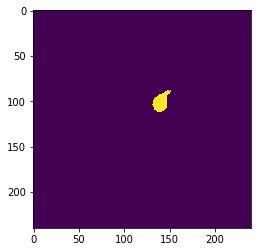

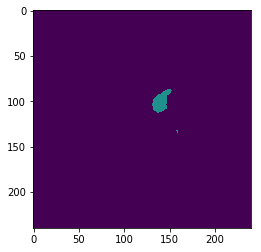

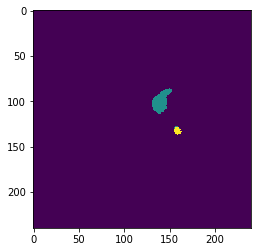

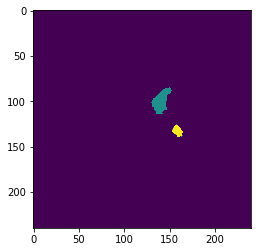

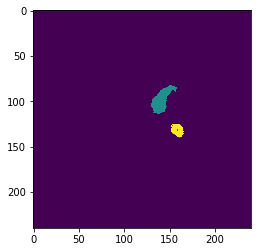

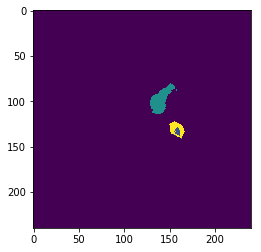

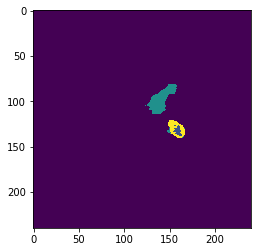

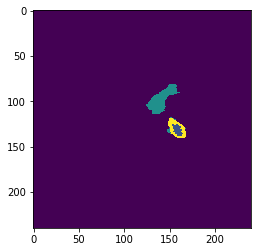

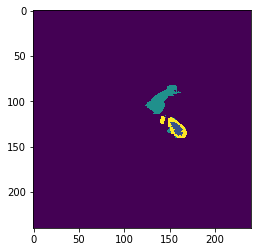

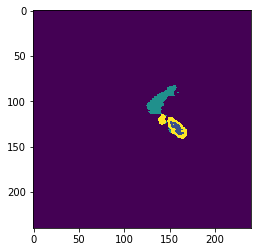

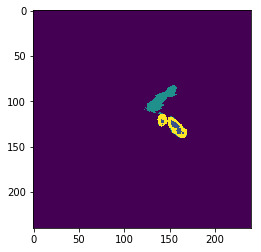

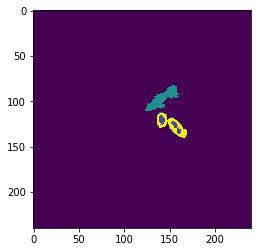

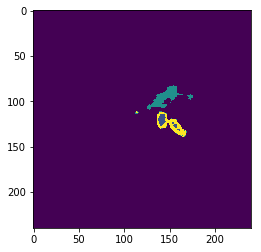

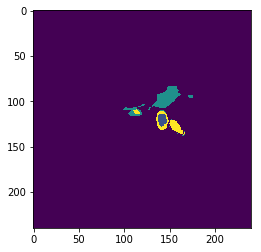

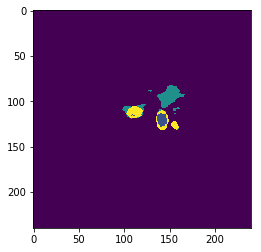

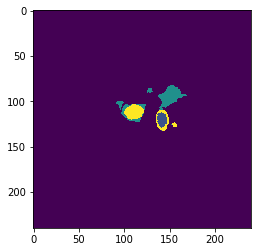

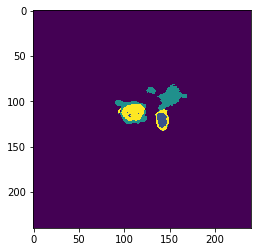

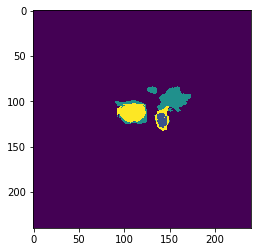

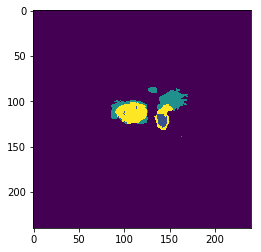

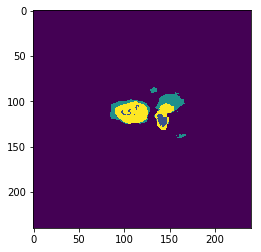

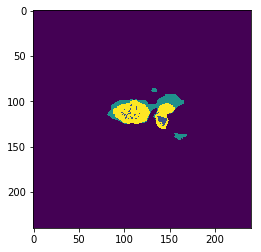

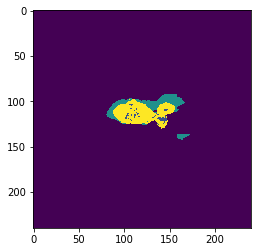

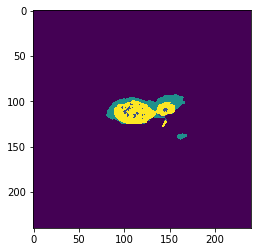

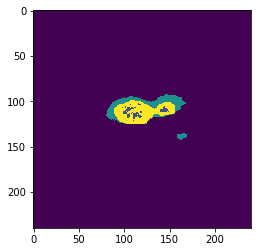

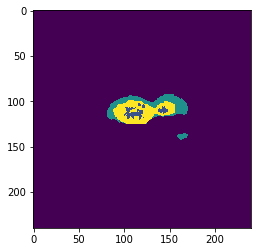

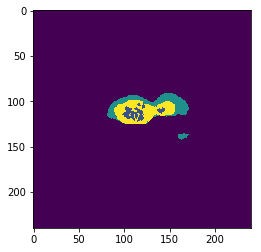

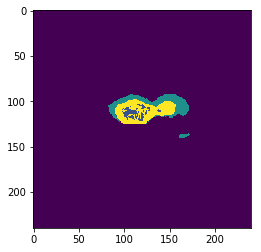

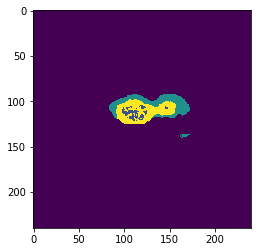

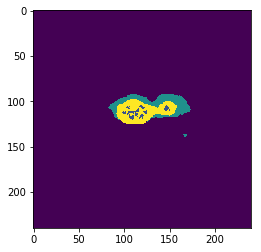

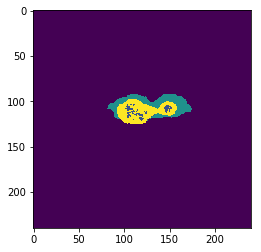

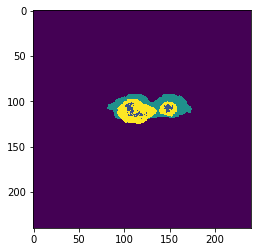

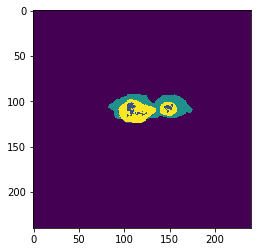

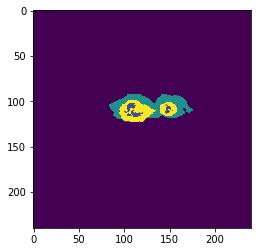

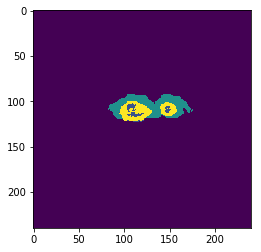

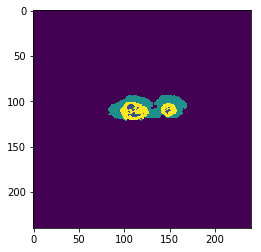

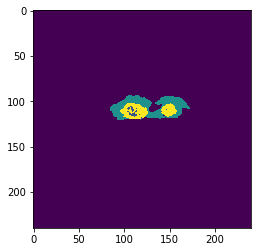

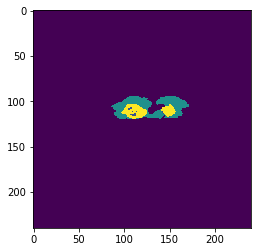

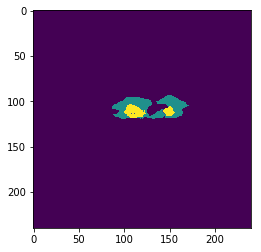

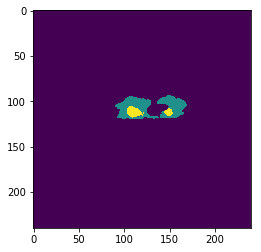

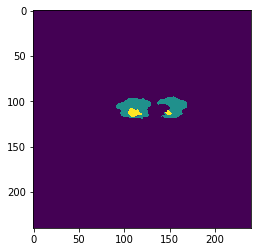

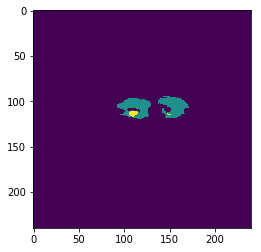

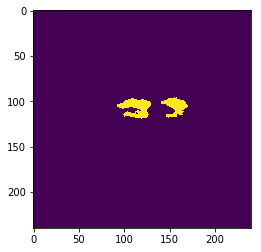

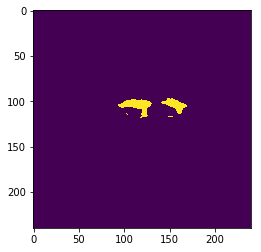

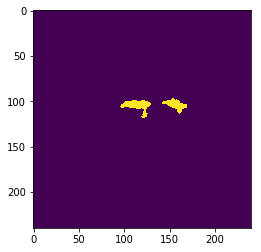

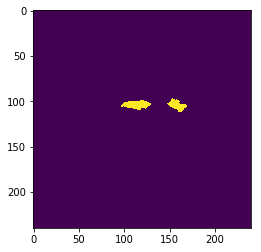

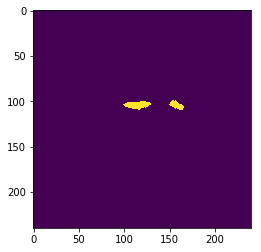

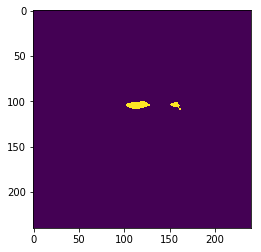

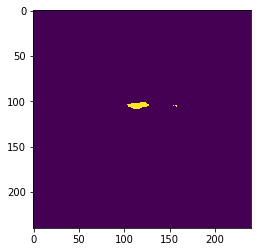

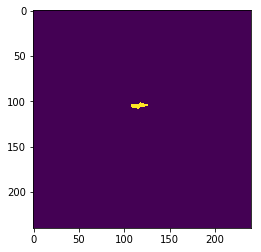

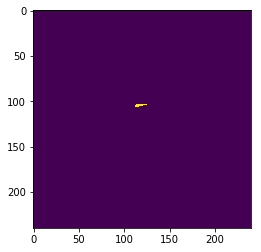

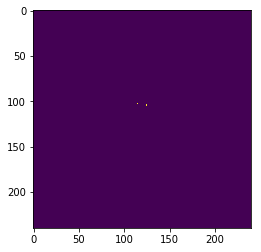

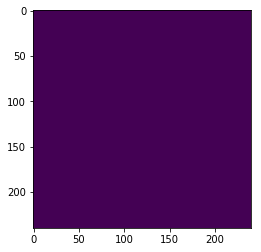

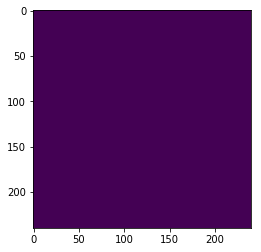

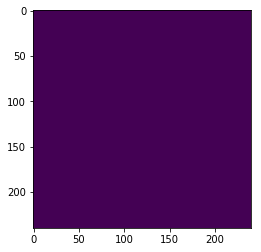

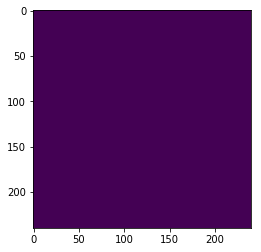

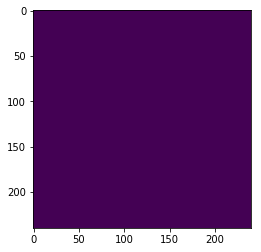

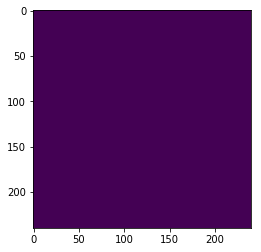

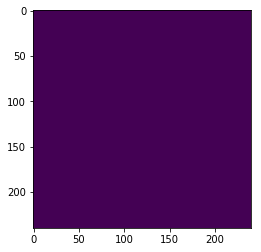

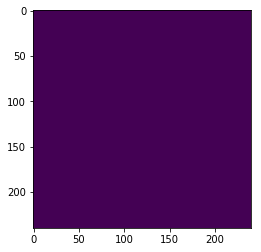

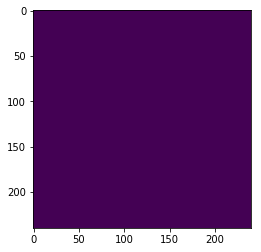

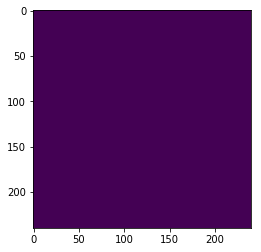

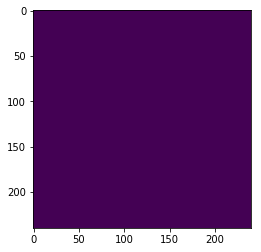

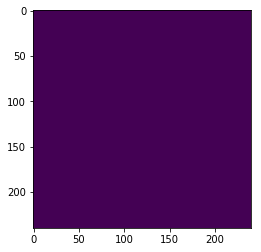

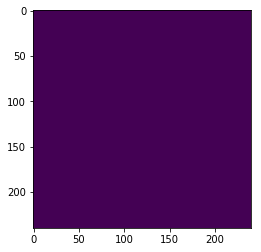

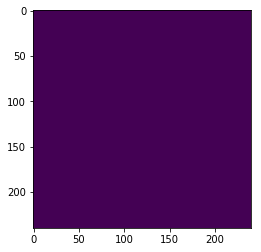

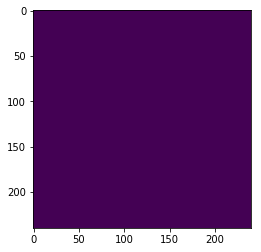

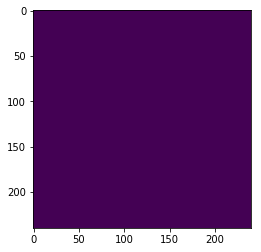

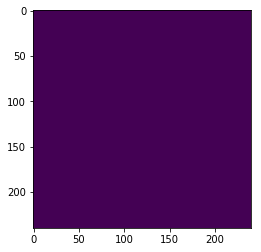

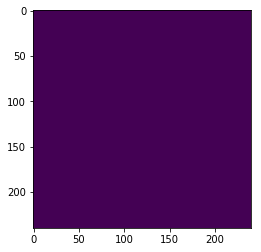

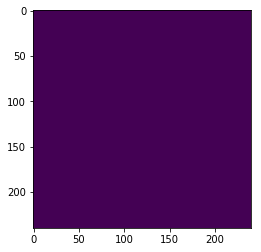

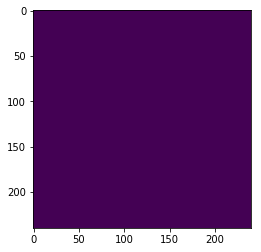

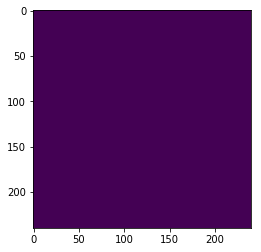

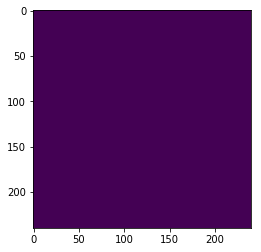

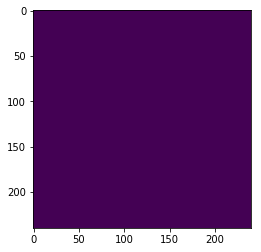

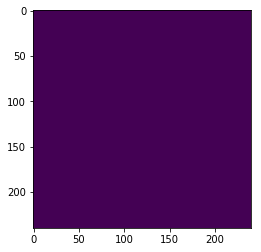

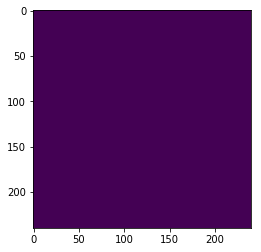

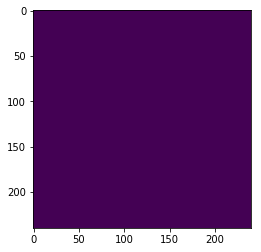

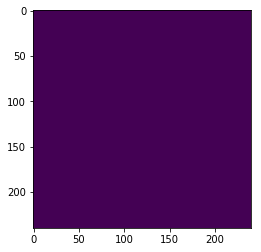

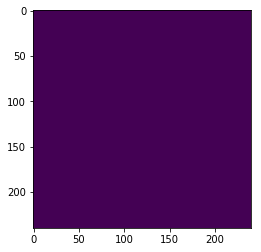

In [32]:
'''nombre_imagen= brats_paciente_zero.split("\\")[-2]
nombre_imagen
img_mask = nib.load(brats_paciente_zero+nombre_imagen+'_seg.nii.gz').get_data()
print(img.shape)
for i in range(0,155):
    plt.imshow(img_mask[:,:,i])
    plt.show()'''

File-path for the TFRecords file holding the training-set.

In [11]:
path_tfrecords_train = os.path.join("C:", "\\Users\\rober\\Practicas\\training\\training_v2.tfrecords")
path_tfrecords_train

'C:\\Users\\rober\\Practicas\\training\\training_v2.tfrecords'

In [12]:
def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [14]:
directorioHGG = glob.glob('C:\\Users\\rober\\Practicas\\MICCAI_BraTS17_Data_Training\\HGG\\*')
print(len(directorioHGG))
directorioLGG = glob.glob('C:\\Users\\rober\\Practicas\\MICCAI_BraTS17_Data_Training\\LGG\\*')
print(len(directorioLGG))
directorio_entrenamiento = directorioHGG[:-209] + directorioLGG[:-74]
directorio_entrenamiento

210
75


['C:\\Users\\rober\\Practicas\\MICCAI_BraTS17_Data_Training\\HGG\\Brats17_2013_10_1',
 'C:\\Users\\rober\\Practicas\\MICCAI_BraTS17_Data_Training\\LGG\\Brats17_2013_0_1']

In [16]:
def norm_image_by_patient(imname):
        im = sitk.GetArrayFromImage(sitk.ReadImage(imname)).astype(np.float32)
        return (im - im.mean()) / im.std()
        roi_index = im > 0
        mean = im[roi_index].mean()
        std = im[roi_index].std()
        im[roi_index] -= mean
        im[roi_index] /= std
        return im

In [17]:
def checkLabel(label, d):
        if np.count_nonzero(label[d]) > 0:
            return True, 1
        else:
            return False, 0

In [18]:
def _processing_image(seq, label, depth):
        seqs = []
        labs = []
        for d in [depth-2, depth-1, depth]:
            label_data = label[d]
            labs.append(np.array(label_data))
            mod = []
            for im in seq:
                image_data = im[d]
                #image_data = scipy.ndimage.interpolation.zoom(image_data, 2, order=1, mode='nearest')
                # upsample 
                mod.append(image_data)
            seqs.append(np.array(mod))
        seqs = np.array(seqs)
        labs = np.array(labs)
        return seqs.tobytes(), labs.tobytes()

In [25]:
def float_feature(value):
    """Wrapper for inserting float features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    if (type(value[0]) == np.float32):
        value = [v.item() for v in value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

In [26]:
## SythText datasets is too big to store in a record. 
## So Transform tfrecord according to dir name

def _convert_to_example(image_data, label):
        #print 'shape: {}, height:{}, width:{}'.format(shape,shape[0],shape[1])
        example = tf.train.Example(features=tf.train.Features(feature={
                'image/encoded': bytes_feature(image_data),
                'label/encoded': bytes_feature(label)
                }))
        return example

In [31]:
with tf.python_io.TFRecordWriter(path_tfrecords_train) as writer:
    all_example = []
    for i,path in enumerate(directorio_entrenamiento):
        print(i,path)
        directorio_paciente = glob.glob(path + '\\*')
        
        
        for(j,path_paciente) in enumerate(directorio_paciente):
            print(j,path_paciente)
            if path_paciente.endswith("flair.nii.gz"):
                print("Entra en flair")
                flair = glob.glob(path_paciente)
                norm_flair = norm_image_by_patient(flair[0])
            if path_paciente.endswith("t2.nii.gz"):
                print("Entra en t2")
                t2 = glob.glob(path_paciente)
                norm_t2 = norm_image_by_patient(t2[0])
            if path_paciente.endswith("t1.nii.gz"):
                print("Entra en t1")
                t1 = glob.glob(path_paciente)
                norm_t1 = norm_image_by_patient(t1[0])
            if path_paciente.endswith("seg.nii.gz"):
                print("Entra en seg")
                label = glob.glob(path_paciente)[0]
                label = sitk.GetArrayFromImage(sitk.ReadImage(label)).astype(np.float32)
            if path_paciente.endswith("t1ce.nii.gz"):
                print("Entra en t1ce")
                t1ce = glob.glob(path_paciente)
                norm_t1ce = norm_image_by_patient(t1ce[0])
            seq = [norm_flair,norm_t2,norm_t1,norm_t1ce]
            '''seq = [norm_image_by_patient(flair[0]),
                norm_image_by_patient(t2[0]),
                norm_image_by_patient(t1[0]),
                norm_image_by_patient(t1ce[0])]'''
            ind = 0
            for depth in range(2,155):
                is_valid, sample_num = checkLabel(label, depth)
                if ( not is_valid):
                    continue
                for i in range(sample_num):
                    image_data, label_data = _processing_image(seq, label, depth)
                    example = _convert_to_example(image_data, label_data)
                    all_example.append(example)
            print("All_example_len",len(all_example))
    print("slices:", len(all_example))
    shuffle(all_example)
    for ex in all_example:
        writer.write(ex.SerializeToString()) 
    print ('Transform to tfrecord finished')

0 C:\Users\rober\Practicas\MICCAI_BraTS17_Data_Training\HGG\Brats17_2013_10_1
0 C:\Users\rober\Practicas\MICCAI_BraTS17_Data_Training\HGG\Brats17_2013_10_1\Brats17_2013_10_1_flair.nii.gz
Entra en flair
All_example_len 48
1 C:\Users\rober\Practicas\MICCAI_BraTS17_Data_Training\HGG\Brats17_2013_10_1\Brats17_2013_10_1_seg.nii.gz
Entra en seg
All_example_len 122
2 C:\Users\rober\Practicas\MICCAI_BraTS17_Data_Training\HGG\Brats17_2013_10_1\Brats17_2013_10_1_t1.nii.gz
Entra en t1
All_example_len 196
3 C:\Users\rober\Practicas\MICCAI_BraTS17_Data_Training\HGG\Brats17_2013_10_1\Brats17_2013_10_1_t1ce.nii.gz
Entra en t1ce
All_example_len 270
4 C:\Users\rober\Practicas\MICCAI_BraTS17_Data_Training\HGG\Brats17_2013_10_1\Brats17_2013_10_1_t2.nii.gz
Entra en t2
All_example_len 344
1 C:\Users\rober\Practicas\MICCAI_BraTS17_Data_Training\LGG\Brats17_2013_0_1
0 C:\Users\rober\Practicas\MICCAI_BraTS17_Data_Training\LGG\Brats17_2013_0_1\Brats17_2013_0_1_flair.nii.gz
Entra en flair
All_example_len 418
1 